In [126]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from dataloader.dataloader import DataLoader
from preprocessing.clustering_segmentation import ClusteringSegmentation
from preprocessing.edge_detection import EdgeDetection
from preprocessing.image_restoration import ImageRestorer
from preprocessing.preproccessing import ImagePreprocessor
from preprocessing.region_segmentation import RegionBasedSegmentation
from preprocessing.threshold_segmentation import ThresholdSegmentation
from feature_extraction.feature_extraction import FeatureExtractor
from feature_selection.feature_selection import FeatureSelector
from model_selection.model_selection import ModelSelection
from performance_analysis.performance_analysis import PerformanceAnalysis

import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Loading

In [127]:
dataloader = DataLoader(Path('./data'))

In [128]:
# Load Data from files
x_train, y_train, x_test, y_test, x_val, y_val = dataloader.load_data()

In [129]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")

x_train shape: (1265, 640, 640, 3)
y_train shape: (1265,)
x_test shape: (278, 640, 640, 3)
y_test shape: (278,)
x_val shape: (278, 640, 640, 3)
y_val shape: (278,)


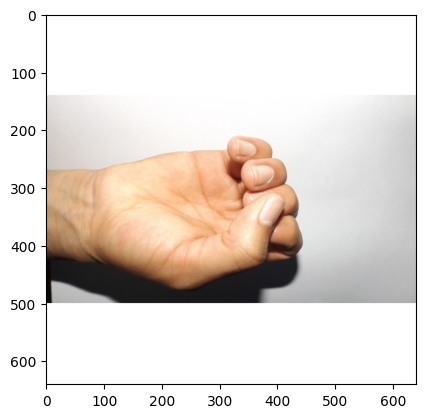

In [130]:
plt.imshow(x_train[100])
plt.show()

## Preprocessing

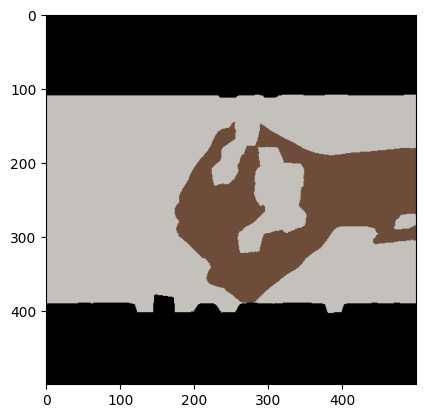

In [131]:
clustering_segmentation = ClusteringSegmentation(method='kmeans', n_clusters=3, compactness=30.0, sigma=1.0)
plt.imshow(clustering_segmentation.process(x_train[0]))
plt.show()

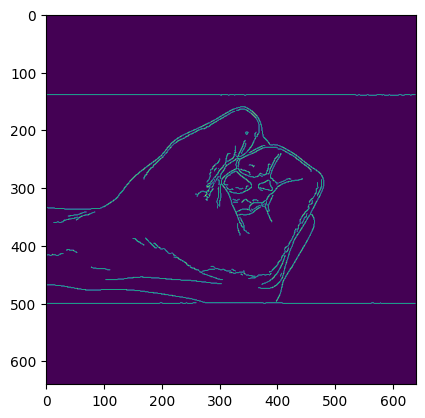

In [132]:
edge_detection = EdgeDetection(method='canny')
#method: for roberts and canny: image must be 2D
plt.imshow(edge_detection.process(x_train[70]))
plt.show()

In [133]:
edge_detection = EdgeDetection(method='canny')
edge_detected_images = edge_detection.process(x_train[:500])

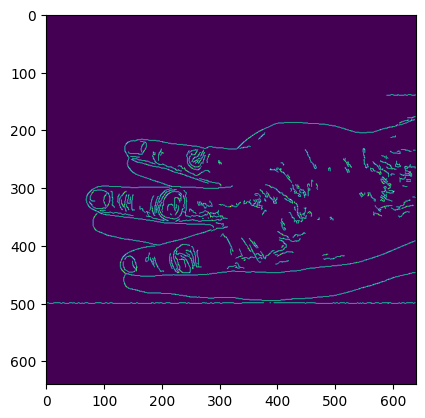

In [134]:
plt.imshow(edge_detected_images[400])
plt.show()

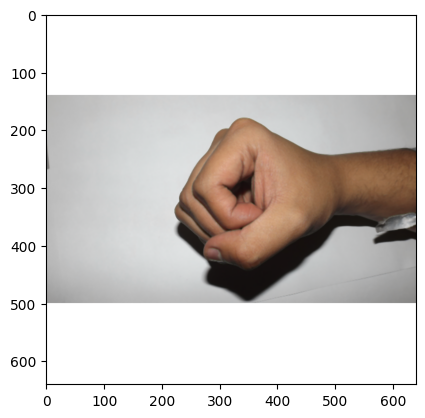

In [135]:
image_restorer = ImageRestorer(method='median')
#'mean_rectangular', 'gaussian', 'adaptive' and 'wiener' generate an error
plt.imshow(image_restorer.process(x_train[0]))
plt.show()

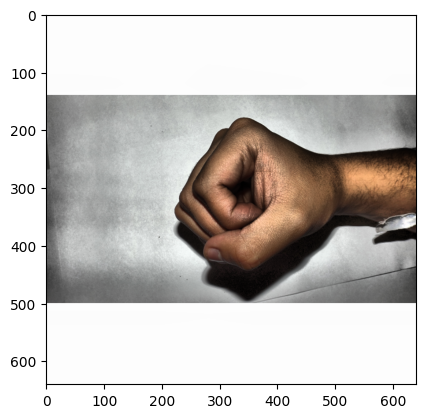

In [136]:
image_preprocessor = ImagePreprocessor(method = 'CLAHE')
# method = 'log' generates an error
plt.imshow(image_preprocessor.process(x_train[0]))
plt.show()

In [137]:
region_based_segmentation = RegionBasedSegmentation(method='region_merging')
# method: 'region_splitting' generates an error
plt.imshow(region_based_segmentation.process(x_train[0]))
plt.show()

ValueError: channel_axis=-1 indicates multichannel, which is not supported for a two-dimensional image; use channel_axis=None if the image is grayscale

## Features Extraction

In [138]:
feature_extractor = FeatureExtractor()

# # HOG FEATURES
# hog_features = feature_extractor.extract_hog_features(rgb2gray(x_train[:10]))
# print(f"hog_features shape: {hog_features.shape}")
# print(f"hog_features: {hog_features}")
# print(np.unique(hog_features))
# print(np.max(hog_features))

# # LCP FEATURES
# lbp_features = []
# for i in range(10):
#     lbp_features.append(feature_extractor.extract_lbp_features(rgb2gray(x_train[i])))
# lbp_features = np.array(lbp_features)
# print(f"lbp_features shape: {lbp_features.shape}")


# sift_features = feature_extractor.extract_sift_features(x_train[:5])
# sift_features = np.array(sift_features)
# print(f"sift_features shape: {sift_features.shape}")



# daisy_features = feature_extractor.extract_daisy_features(rgb2gray(x_train[:25]))
# print(f"daisy_features shape: {daisy_features.shape}")


# FOURIER DESCRIPTOR FEATURES (error)
# fourier_descriptor_features = []
# for i in range(10):
#     fourier_descriptor_features.append(feature_extractor.extract_fourier_descriptor_features(X_train[i]))
# fourier_descriptor_features = np.array(fourier_descriptor_features)
# print(f"fourier_descriptor_features shape: {fourier_descriptor_features.shape}")

# SURF FEATURES (error)

# surf_features = feature_extractor.extract_surf_features(x_train[0:10])
# print(f"surf_features shape: {surf_features.shape}")


# ORB FEATURES

# orb_features = feature_extractor.extract_orb_features(x_train[:10])
# print(f"orb_features shape: {orb_features.shape}")

In [139]:
feature_extractor = FeatureExtractor()
hog_features = feature_extractor.extract_hog_features(edge_detected_images)

In [140]:
print(f"hog_features shape: {hog_features.shape}")

hog_features shape: (500, 12800)


## Feature Selection

In [142]:
feature_selector = FeatureSelector()

# PCA FEATURES

pca_features =  feature_selector.extract_pca_features(hog_features, load=False)
print(f"pca_features shape: {pca_features.shape}")

Creating new PCA model...
pca_features shape: (500, 20)


## Model Selection

In [ ]:
# true_labels is just for trial here
true_labels = np.concatenate((np.zeros(10), np.ones(10) * 3))
model_selection = ModelSelection(
    hog_features[:15], true_labels[:15], hog_features[15:], true_labels[15:]
)
knn, pred_train, pred_val = model_selection.KNN()
print(pred_train)


In [ ]:
performance_analysis = PerformanceAnalysis('KNN', pred_train, true_labels[15:])
performance_analysis.calculate_performance_metrics()